## Import data from Kaggle to Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seojeong1105","key":"a63ce81a6f6cd29b58fd09ee933a7273"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ishantjuyal/emotions-in-text

  0% 0.00/781k [00:00<?, ?B/s]
100% 781k/781k [00:00<00:00, 120MB/s]


In [ ]:
import pickle
import re
import string
import time
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.utils import shuffle
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Get dataset from Kaggle

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("emotions-in-text.zip", "r")
zip_ref.extractall("files")
zip_ref.close()
import pandas as pd
df=pd.read_csv("/content/files/Emotion_final.csv")

In [ ]:
df = shuffle(df)
df.reset_index(inplace=True, drop=True)
dataset = df
dataset.head()

,Text,Emotion
0,i feel like doing or not doing its mind numbin...,sadness
1,i just feel like its rude,anger
2,i still feel vulnerable and hurt but its manag...,fear
3,i have trusted mike with some deeply personal ...,happy
4,i feel so contented just by relieving the scen...,happy


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


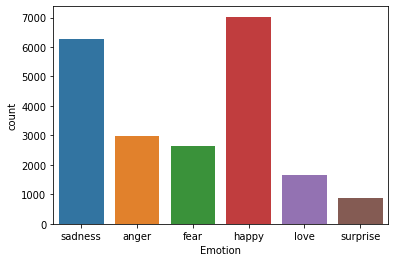

In [ ]:
sns.countplot(dataset.Emotion)
plt.show()

## Preprocessing

In [ ]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
dataset['Label'] = encoder.fit_transform(dataset['Emotion'])
dataset.head(5)

,Text,Emotion,Label
0,i feel like doing or not doing its mind numbin...,sadness,4
1,i just feel like its rude,anger,0
2,i still feel vulnerable and hurt but its manag...,fear,1
3,i have trusted mike with some deeply personal ...,happy,2
4,i feel so contented just by relieving the scen...,happy,2


In [ ]:
possible_labels = dataset.Emotion.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = dataset[dataset['Emotion'] == possible_label].Label.values[0]
label_dict

{'anger': 0, 'fear': 1, 'happy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}

In [ ]:
def cleaning_text(text):
    text = text.replace("\r", "")
    text = text.lower()
    text = re.sub('r<.*?>', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'http\S+', " ", text)

    text = text.split()
    stop_words = stopwords.words("english")
    text = " ".join([word for word in text if not word in stop_words])

    for punctuation in string.punctuation:
        text = text.replace(punctuation, "")

    return text

dataset['Text'] = dataset['Text'].apply(lambda x: cleaning_text(x))

In [ ]:
num_classes = dataset.Label.nunique()
res = Counter()
dataset['Text'].str.split().apply(res.update)
dim_dic = len(res.keys())

# Maximum sentence length
max_len_words = max(list(dataset['Text'].apply(len)))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(dataset.Text, dataset.Label,
                                                  test_size=.2, shuffle=True,
                                                  stratify=dataset.Label, random_state=3)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
                                                  test_size=.2, shuffle=True,
                                                  stratify=Y_train, random_state=3)

## BertTokenizer and Encoding the Data

In [ ]:
!pip install transformers command

     |████████████████████████████████| 4.2 MB 4.0 MB/s 
     |████████████████████████████████| 596 kB 45.2 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 6.6 MB 33.0 MB/s 
  Created wheel for command: filename=Command-0.1.0-py3-none-any.whl size=6413 sha256=705c417345335acc03354b1a2e64803d3549a8468657f3dc0480813e1f93e24c
  Stored in directory: /root/.cache/pip/wheels/92/70/7c/aced46d2f5ef04e9dfe360f131b2ba8dacd929c131eee12b13
Successfully built command
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [ ]:
print(Y_train.values)

[3 1 4 ... 4 2 0]


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    X_train,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_val,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    X_test,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(Y_train.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(Y_val.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(Y_test.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


##BERT Pre-trained Model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=num_classes,
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      hidden_dropout_prob = 0.2,
                                                      attention_probs_dropout_prob = 0.2)
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

##Data Loaders

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 8

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

dataloader_test = DataLoader(dataset_test,
                                   sampler=SequentialSampler(dataset_test),
                                   batch_size=batch_size)

##Optimizer & Scheduler

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup



optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 6

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


##Performance Metrics

In [ ]:
from sklearn.metrics import f1_score
import datetime

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    total_pred = 0
    total_true = 0
    result = ''
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        result += f'Class: {label_dict_inverse[label]} Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n'
        total_pred += len(y_preds[y_preds==label] )
        total_true += len(y_true)

    result += f'Total Accuracy: {total_pred}/{total_true}\n'
    return result
        # print(f'Class: {label_dict_inverse[label]}')
        # print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

##evaluation Function

In [ ]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

##Training Loop


In [ ]:
import random
import time

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

train_loss = []
valid_loss = []

#load check point
start_epoch = 0
# checkpoint = torch.load('/content/drive/MyDrive/2022_Al_project/bert_model/BERT_epoch_1.model')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler'])
# start_epoch = checkpoint['epoch']
# model.train()

model.zero_grad()

for epoch in tqdm(range(start_epoch+1, epochs+1)):

    model.train()

    t0 = time.time()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    tqdm.write(f'{accuracy_per_class(predictions, true_vals)}')

    train_loss.append(loss_train_avg)
    valid_loss.append(val_loss)



NameError: ignored

##Draw Graph

In [ ]:
print(train_loss)
plt.plot(train_loss, label = "train_loss")
plt.plot(valid_loss, label = "valid_loss")
plt.title('Loss At Epoch')
plt.legend()

##Loading and Evaluating the Model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/2022_Al_project/BERT_epoch_7.model', map_location=torch.device('cpu'))['model_state_dict'])

_, predictions, true_vals = evaluate(dataloader_test)
print(accuracy_per_class(predictions, true_vals))

##lyrics

In [ ]:
dataset_tsv = pd.read_csv('/content/drive/MyDrive/2022_Al_project/lyrics_dataset.tsv',sep='\t',  lineterminator='\n')
dataset_tsv['Emotion'] = dataset_tsv['sentiment\r'].apply(lambda x: cleaning_text(x))
dataset_tsv['Label'] = encoder.fit_transform(dataset_tsv['Emotion'])
dataset_tsv['data'] = dataset_tsv['data'].apply(lambda x: cleaning_text(x))

X_lyrics = dataset_tsv['data']
Y_lyrics = dataset_tsv['Label']

# Y_lyrics


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

encoded_data_lyrics = tokenizer.batch_encode_plus(
    X_lyrics,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_lyrics = encoded_data_lyrics['input_ids']
attention_masks_lyrics = encoded_data_lyrics['attention_mask']
labels_lyrics = torch.tensor(Y_lyrics.values)

dataset_lyrics = TensorDataset(input_ids_lyrics, attention_masks_lyrics, labels_lyrics)

dataloader_lyrics = DataLoader(dataset_lyrics,
                              sampler=RandomSampler(dataset_lyrics),
                              batch_size=batch_size)

_, predictions, true_vals = evaluate(dataloader_lyrics)
print(accuracy_per_class(predictions, true_vals))


##poem

In [ ]:
dataset_tsv = pd.read_csv('/content/drive/MyDrive/2022_Al_project/poem_dataset.tsv',sep='\t',  lineterminator='\n')
# dataset_tsv
dataset_tsv['Emotion'] = dataset_tsv['emotion\r'].apply(lambda x: cleaning_text(x))
dataset_tsv['Label'] = encoder.fit_transform(dataset_tsv['Emotion'])
dataset_tsv['data'] = dataset_tsv['data'].apply(lambda x: cleaning_text(x))

X_poem= dataset_tsv['data']
Y_poem = dataset_tsv['Label']

# Y_poem


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

encoded_data_poem = tokenizer.batch_encode_plus(
    X_poem,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_poem = encoded_data_poem['input_ids']
attention_masks_poem = encoded_data_poem['attention_mask']
labels_poem = torch.tensor(Y_poem.values)

dataset_poem = TensorDataset(input_ids_poem, attention_masks_poem, labels_poem)

dataloader_poem = DataLoader(dataset_poem,
                              sampler=RandomSampler(dataset_poem),
                              batch_size=batch_size)

_, predictions, true_vals = evaluate(dataloader_poem)
print(accuracy_per_class(predictions, true_vals))


##Youtube Comment


In [ ]:
dataset_tsv = pd.read_csv('/content/drive/MyDrive/2022_Al_project/YouTube_Comments_dataset.tsv',sep='\t',  lineterminator='\n')
# dataset_tsv
dataset_tsv['Emotion'] = dataset_tsv['emotion\r'].apply(lambda x: cleaning_text(x))
dataset_tsv['Label'] = encoder.fit_transform(dataset_tsv['Emotion'])
dataset_tsv['data'] = dataset_tsv['data'].apply(lambda x: cleaning_text(x))

X_comment = dataset_tsv['data']
Y_comment = dataset_tsv['Label']


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

encoded_data_comment = tokenizer.batch_encode_plus(
    X_comment,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_comment = encoded_data_comment['input_ids']
attention_masks_comment = encoded_data_comment['attention_mask']
labels_comment = torch.tensor(Y_comment.values)

dataset_comment = TensorDataset(input_ids_comment, attention_masks_comment, labels_comment)

dataloader_comment = DataLoader(dataset_comment,
                              sampler=RandomSampler(dataset_comment),
                              batch_size=batch_size)

_, predictions, true_vals = evaluate(dataloader_comment)
print(accuracy_per_class(predictions, true_vals))


##Novel


In [ ]:
dataset_tsv = pd.read_csv('/content/drive/MyDrive/2022_Al_project/novel_dataset.tsv',sep='\t',  lineterminator='\n')
# dataset_tsv
dataset_tsv['emotion'] = dataset_tsv['emotion\r'].apply(lambda x: cleaning_text(x))
dataset_tsv['Label'] = encoder.fit_transform(dataset_tsv['emotion'])
dataset_tsv['data'] = dataset_tsv['data'].apply(lambda x: cleaning_text(x))
# dataset_tsv
X_novel = dataset_tsv['data']
Y_novel = dataset_tsv['Label']


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

encoded_data_novel = tokenizer.batch_encode_plus(
    X_novel,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_novel = encoded_data_novel['input_ids']
attention_masks_novel = encoded_data_novel['attention_mask']
labels_novel = torch.tensor(Y_novel.values)

dataset_novel = TensorDataset(input_ids_novel, attention_masks_novel, labels_novel)

dataloader_novel = DataLoader(dataset_novel,
                              sampler=RandomSampler(dataset_novel),
                              batch_size=batch_size)

_, predictions, true_vals = evaluate(dataloader_novel)
print(accuracy_per_class(predictions, true_vals))
